<h1 style="color:SKYBLUE;"><center>Prosper Loan Data Insights</center></h1>


<h2 style="color:SKYBLUE;">By Jinning Lyu</h2>

<h1 style="color:SKYBLUE;"><center>Introduction</center></h1>
Prosper is a leading P2P marketplace. It allows borrowers requesting personal loans via Prosper, and the investors can provide funding from 2,000 dollars to 40,000 dollars for each request. In order to make good investment decisions, lenders assess the borrowers from different prospectives. This report conducts a decent analysis on the Prosper loan dataset to answer the following questions: 

* Is there any pattern or trend of the loan size?
* How does the length of the loan (Term) affect the lenders Estimated Return?
* Does being a homeowner affect the amount people borrow?
* Who can get a large loan?
* How to maximize the lender yield?


In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

In [3]:
# import dataset
df = pd.read_csv('prosperLoanData.csv')

In [4]:
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

<h1 style="color:SKYBLUE;"><center>General properties of the Prosper Loan Data</center></h1>
There are four kinds of variable catogries in this dataset:

* **Loan status**: The status of an individual listing. Investors can expect to get the detail information of a loan, for instance, status, terms, closedDate, borrower APR and rate etc..

* **Borrowers' personal data**: The personal and credit information such as employment status, Isborrowerhomeowner. 

* **Borrowers' credit data**: The basic properties of the borrower's present and previous credit records, for instance, credit lines, public records etc..

* **Prosper Loan data**: the borrowers' records and loans on Prosper, for instance, total prosper loans, on time Prosper payments.

Borrowers are generally concerned about the criteria for application of loans, while investors are more likely to be concern about choosing a trustful borrower and maximize the yield. By answering all the questions mentioned above, both borrowers and investors will have insights on how to reach their goals.

# Data Wrangling
In this section, we assess an clean the dataset for furture analysis. 

Data type of some numerical variables are float but they are actually integer variables， for instance the credit lines. As it can be cumbersome to handle float variales, a function is used to check if a variable should be converted to 'int' type.

In [6]:
df_clean = df.copy()

In [7]:
# a function to heck if float variables can be replaced by integer variables
def check_dtype(df,column):
    # if the elements are all integer, convert the variable to 'int64'
    convert = df[column].fillna(0).astype('int64').astype('float')
    if (df[column].fillna(0) == convert).all():
        pass
    else: print(column + ': Keep the present data type')

In [8]:
# Checking all the relavant columns
check_column = ['CurrentCreditLines', 'OpenCreditLines','TotalCreditLinespast7years','InquiriesLast6Months', 'TotalInquiries','CurrentDelinquencies','AmountDelinquent','DelinquenciesLast7Years', 'PublicRecordsLast10Years','PublicRecordsLast12Months','RevolvingCreditBalance','AvailableBankcardCredit','TotalTrades','TradesOpenedLast6Months','TotalProsperLoans','OnTimeProsperPayments','ProsperPaymentsLessThanOneMonthLate','ProsperPaymentsOneMonthPlusLate','ScorexChangeAtTimeOfListing','LoanFirstDefaultedCycleNumber']
for column in check_column:
    check_dtype(df_clean,column)

All the variables checked above are converted to 'int64'.

## Data assessing
### Quality issues
* ListingKey and ListingNumbers are repetitive in terms of identification of listing
* Erroneous Dtype:
    * Date: `ListingCreationDate`,`ClosedDate`,`ListingCategory (numeric)`,`DateCreditPulled`,`FirstRecordedCreditLine`,`LoanOriginationDate`
    
    * float to int: `CurrentCreditLines`, `OpenCreditLines`,`TotalCreditLinespast7years`,`InquiriesLast6Months`, `TotalInquiries`,`CurrentDelinquencies`,`AmountDelinquent`,`DelinquenciesLast7Years`, `PublicRecordsLast10Years`,`PublicRecordsLast12Months`,`RevolvingCreditBalance`,`AvailableBankcardCredit`,`TotalTrades`,`TradesOpenedLast6Months`,`TotalProsperLoans`,`OnTimeProsperPayments`,`ProsperPaymentsLessThanOneMonthLate`,`ProsperPaymentsOneMonthPlusLate`,`ScorexChangeAtTimeOfListing`,`LoanFirstDefaultedCycleNumber`
    * IncomeRange: "$0" and "Not Employed" are repetitive.

### Tidiness issues:

* Repetitive: ProsperRating (numeric), ProsperRating (Alpha)

Fix Erroneous data type

In [9]:
# convert date variables to datetime format
col_to_date = ['ListingCreationDate','ClosedDate','DateCreditPulled','FirstRecordedCreditLine','LoanOriginationDate']
for column in col_to_date:
    df_clean[column] = pd.to_datetime(df_clean[column])

In [10]:
# test
df_clean[col_to_date].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   ListingCreationDate      113937 non-null  datetime64[ns]
 1   ClosedDate               55089 non-null   datetime64[ns]
 2   DateCreditPulled         113937 non-null  datetime64[ns]
 3   FirstRecordedCreditLine  113240 non-null  datetime64[ns]
 4   LoanOriginationDate      113937 non-null  datetime64[ns]
dtypes: datetime64[ns](5)
memory usage: 4.3 MB


In [11]:
# convert checked variables to int format
col_to_int = ['CurrentCreditLines', 'OpenCreditLines','TotalCreditLinespast7years','InquiriesLast6Months', 'TotalInquiries','CurrentDelinquencies','AmountDelinquent','DelinquenciesLast7Years', 'PublicRecordsLast10Years','PublicRecordsLast12Months','RevolvingCreditBalance','AvailableBankcardCredit','TotalTrades','TradesOpenedLast6Months','TotalProsperLoans','OnTimeProsperPayments','ProsperPaymentsLessThanOneMonthLate','ProsperPaymentsOneMonthPlusLate','ScorexChangeAtTimeOfListing','LoanFirstDefaultedCycleNumber']
for column in col_to_int:
    df_clean[column] = df_clean[column].fillna(0).astype('int64')

In [12]:
# test
df_clean[col_to_int].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 20 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   CurrentCreditLines                   113937 non-null  int64
 1   OpenCreditLines                      113937 non-null  int64
 2   TotalCreditLinespast7years           113937 non-null  int64
 3   InquiriesLast6Months                 113937 non-null  int64
 4   TotalInquiries                       113937 non-null  int64
 5   CurrentDelinquencies                 113937 non-null  int64
 6   AmountDelinquent                     113937 non-null  int64
 7   DelinquenciesLast7Years              113937 non-null  int64
 8   PublicRecordsLast10Years             113937 non-null  int64
 9   PublicRecordsLast12Months            113937 non-null  int64
 10  RevolvingCreditBalance               113937 non-null  int64
 11  AvailableBankcardCredit              11

In [13]:
# Since not employed borrower have no income, integrate the "Not employed" to "0$" income.
df_clean.replace({'IncomeRange': {"Not employed": "$0"}},inplace=True)
df_clean.IncomeRange.value_counts()

$25,000-49,999    32192
$50,000-74,999    31050
$100,000+         17337
$75,000-99,999    16916
Not displayed      7741
$1-24,999          7274
$0                 1427
Name: IncomeRange, dtype: int64

In [14]:
# drop the repetitive variable 'ProsperRating (numeric)'
col_drop=['ProsperRating (numeric)']
df_clean.drop(columns = col_drop, inplace= True)

In [15]:
# fill NAN in CreditGrade to 'N/A' for future analysis
df_clean.CreditGrade.fillna('N/A',inplace=True)

In [16]:
# replace the number of months with more descriptive phrases.
df_clean.Term = df_clean.Term.replace([12,36,60],['1_year','3_year','5_year'])

In [17]:
# Replace all kinds of past due statuses with the 'Past Due' status.
df_clean.LoanStatus = df_clean.LoanStatus.replace(['Past Due (1-15 days)','Past Due (16-30 days)',
                                             'Past Due (31-60 days)','Past Due (61-90 days)',
                                             'Past Due (91-120 days)','Past Due (>120 days)'
                                            ],
                                            ['Past Due','Past Due','Past Due','Past Due','Past Due','Past Due'])

In [18]:
df_clean.shape

(113937, 80)

In [19]:
df_analysis = df_clean.copy()

Now the clean dataset has 113937 rows and 80 columns. Let's go to the fun part, data analysis!

# Data Analysis
In this section, data are analysed by the following orders:
* Univariate analysis
* Bivariate analysis
* Multivariate analysis

According to the variable explanation, the entire dataset is divided into two sections at 2009.

In [20]:
df_pre_2009 = df_analysis.query('ListingCreationDate < datetime.date(2009, 1, 1)')

In [21]:
df_post_2009 = df_analysis.query('ListingCreationDate > datetime.date(2009, 12, 31)')

## Univariate Analysis

<h1 style="color:SKYBLUE;"><center>For borrowers</center></h1>

In [22]:
# A function for ticks generation, only work for numerical ticks.
def set_ticks(upper,lower,step,unit,axis,tick_step=None):
    ticks = np.arange(upper,lower,step)
    if tick_step == None:
        if unit == 'K':
            tick_step = 1000
        if unit == 'M':
            tick_step = 1000000
    else: pass
    labels = [str(int(i/tick_step)) + unit for i in ticks]
    if axis == 'x':
        plt.xticks(ticks,labels)
    if axis == 'y':
        plt.yticks(ticks,labels)

In [23]:
# A function for custimization of x label, y label and title.
def set_labels(x_label,y_label,title=False,Legend=False):
    plt.xlabel(x_label.title(),
               fontsize = 15, weight = "bold")
    plt.ylabel(y_label.title(),
               fontsize = 15, weight = "bold");
    if not title:
        plt.title((y_label + ' vs. ' + x_label).title(),
               fontsize = 20, weight = "bold")
    else: plt.title(title.title(),
               fontsize = 20, weight = "bold")
    if Legend:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
               title=Legend, title_fontsize = 12);

In [24]:
# define the approprate figure size for A4 reports and computer screen
report = [11.69, 8.27]
computer = [14.70, 8.27]

**Credit Rate**
Most of the borrowers have the credit rate higher than 'HR'. Level 'C' has the largest counts followes by 'D','B','HR','AA','A' and 'E'

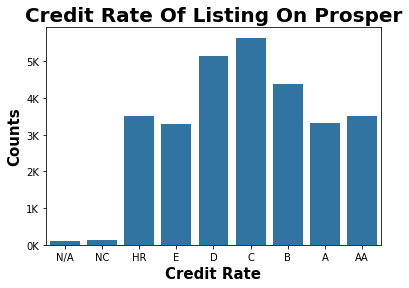

In [25]:
c = sns.color_palette()[0]
y_order = ['N/A','NC','HR','E','D','C','B','A','AA']
groupedvalues = df_pre_2009.CreditGrade.value_counts()
fig = sns.barplot(groupedvalues.index,groupedvalues.values,color = c,order=y_order)
set_ticks(0,6000,1000,'K','y')
set_labels('Credit Rate','Counts','Credit Rate of Listing on Prosper')

**Term**
3-year term loan is quite popular among borrowers since more than 70% of borrowers choose this kind of loan.

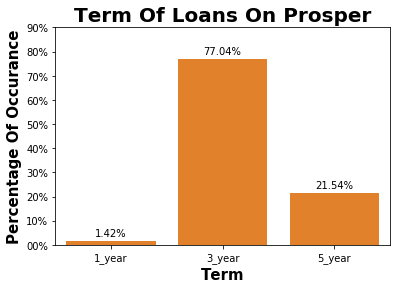

In [26]:
c = sns.color_palette()[1] # choose a color for the plot

# calculate the proportion of each catogary.
x_order = ['1_year','3_year','5_year']
groupedvalues = df_analysis.Term.value_counts()
g = sns.barplot(groupedvalues.index,groupedvalues.values*100/df_analysis.shape[0],color = c,order=x_order)

# barplot
for i in range(len(x_order)):
    value = sum(df_analysis.Term == x_order[i])/df_analysis.shape[0]
    g.text(i,round(value*100,2)+2,str(round(value*100,2))+'%',color='black', ha="center")
    
# reset ticks, labels and title    
set_ticks(0,100,10,'0%','y',10)
set_labels('Term','Percentage of Occurance','Term of Loans on Prosper');
plt.savefig('Term')

**Loan Status**
Approximate half of the loans are undergoing now. Noticeably that about 11% of the loans are charged-off and 1.81% past the deadline.

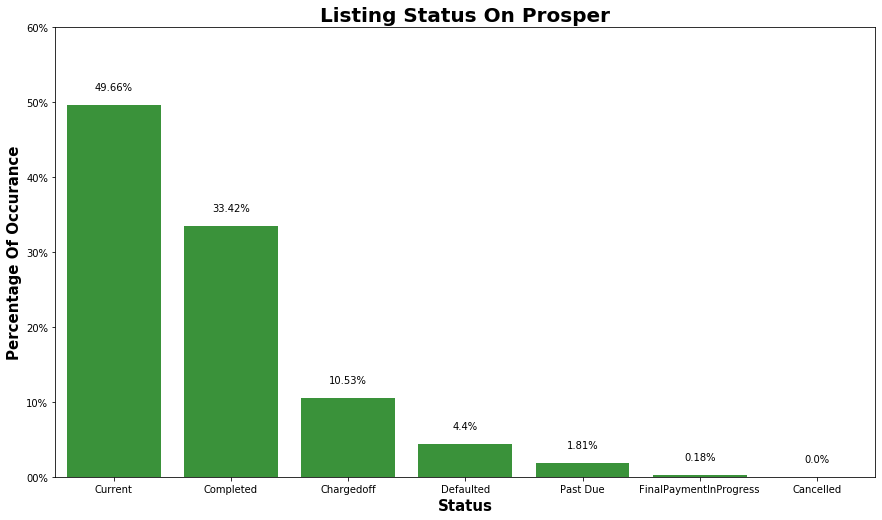

In [27]:
# plot loan status
c = sns.color_palette()[2] # choose a color for the plot

fig, ax = plt.subplots(figsize = computer)

x_order = df_analysis.LoanStatus.value_counts().index # define the order of catogaries.

# calculate the proportion of each catogary.
groupedvalues = df_analysis.LoanStatus.value_counts()
g = sns.barplot(groupedvalues.index,groupedvalues.values*100/df_analysis.shape[0],color = c,order=x_order,ax=ax)

# plot
for i in range(len(x_order)):
    value = sum(df_analysis.LoanStatus == x_order[i])/df_analysis.shape[0]
    g.text(i,round(value*100,2)+2,str(round(value*100,2))+'%',color='black', ha="center")

# reset ticks, labels and title
set_ticks(0,70,10,'0%','y',10)
set_labels('Status','Percentage of Occurance','Listing Status on Prosper');
plt.savefig('Status')

**LenderYield**
Before 2009, the lender yield distribution is right skewed with an average yield of 0.17. After 2009, the lender yield distributes relative uniform with an average yield of 0.19. Noticeably, there is a peak in both distributions above 0.3.

In [28]:
# calculate the average lender yield before and after 2009.
round(df_pre_2009['LenderYield'].mean(),2),round(df_post_2009['LenderYield'].mean(),2)

(0.17, 0.19)

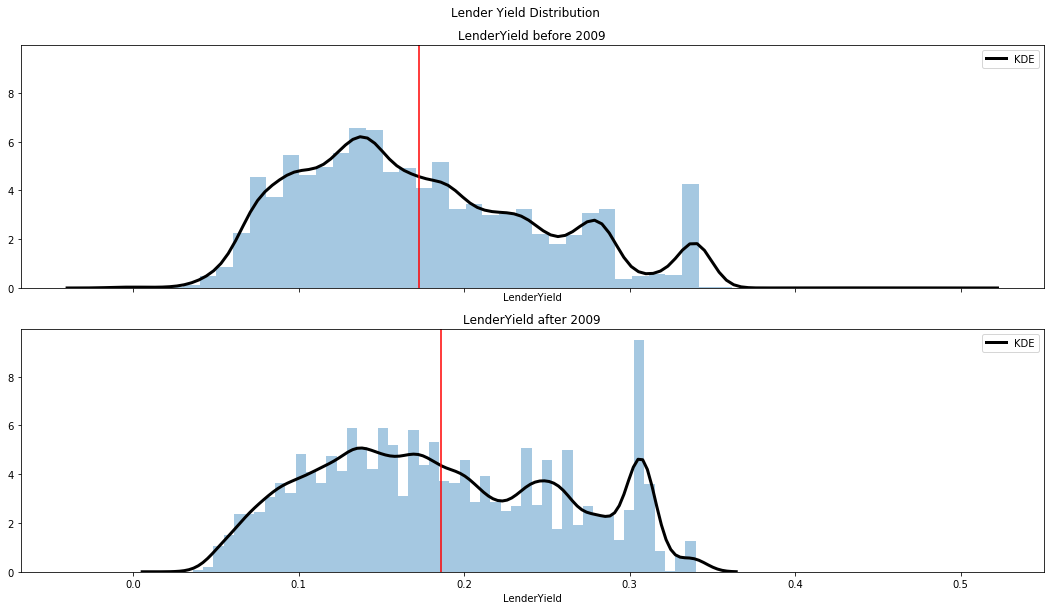

In [29]:
# lender yield trend plot

fig,axs = plt.subplots(2,1,figsize=computer,sharex=True, sharey=True)
plt. subplots_adjust(hspace=0.5)

# first subplot - lender yield distribution BEFORE 2009
sns.distplot(df_pre_2009['LenderYield'],
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                 ax = axs[0])
axs[0].set_title('LenderYield before 2009')
axs[0].axvline(x = df_pre_2009['LenderYield'].mean(),color='r')
ax.set_ylabel('common ylabel');

# second subplot - lender yield distribution AFTER 2009
sns.distplot(df_post_2009['LenderYield'],
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  ax = axs[1])
plt.axvline(x = df_post_2009['LenderYield'].mean(),color='r')
axs[1].set_title('LenderYield after 2009');

plt.suptitle("Lender Yield Distribution", y = 1.02)
plt.tight_layout();

**LoanOriginalAmount**
The distribution shows that the loan original amount peaks at 5K,10K,15K,20K,25K,30K and 35K, while there are tiny peaks between two high peaks. These peaks indicates that Prosper offers loan at different levels while borrowers have the flexibility to loan money between these levels.

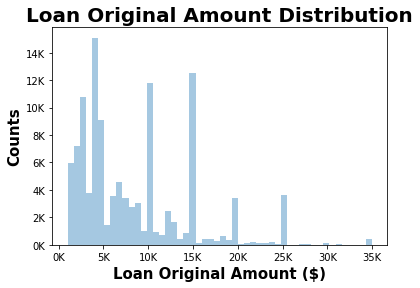

In [30]:
sns.distplot(df_analysis.LoanOriginalAmount,kde=False)
set_ticks(0,40000,5000,'K','x',1000)
set_ticks(0,15000,2000,'K','y',1000)
set_labels('Loan Original Amount ($)','Counts','Loan Original Amount Distribution');

The distribution shows that the loan original amount peaks at 5K,10K,15K,20K,25K,30K, 40K and 50K, while there are tiny peaks between two high peaks. These peaks indicates that Prosper offers loan at different levels while borrowers have the flexibility to loan money between these levels.

## Bivariate analysis

<h3 style="color:SKYBLUE;"><center>Is there any pattern or trend of the loan size?</center></h3>

In [31]:
sub_df = df_analysis[['LoanOriginalAmount','LoanOriginationDate']]
sub_df_agg = sub_df.groupby('LoanOriginationDate')['LoanOriginalAmount'].sum()

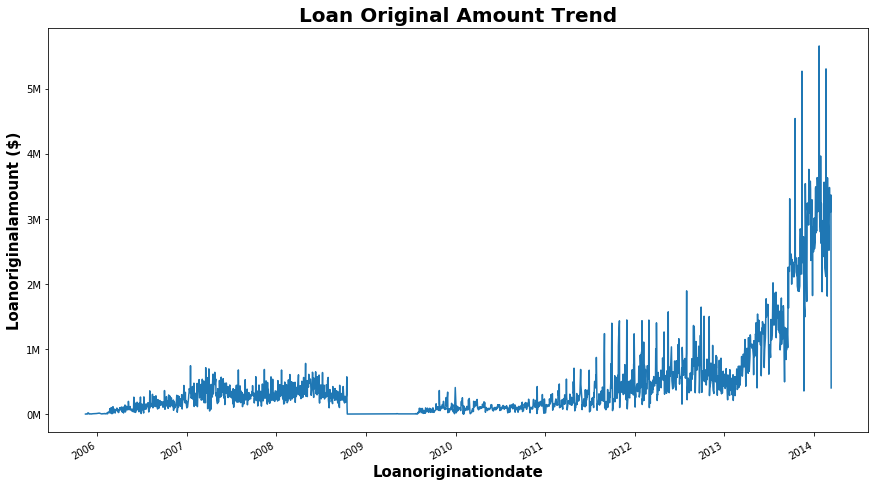

In [32]:
plt.figure(figsize=computer)

sub_df_agg.plot.line(x = 'LoanOriginationDate',y = sub_df_agg.values)
set_ticks(0,6000000,1000000,'M','y')
set_labels('LoanOriginationDate','LoanOriginalAmount ($)','Loan Original Amount Trend')


In [33]:
# calculate de-trended and lag
de_trend = (sub_df_agg - sub_df_agg.rolling(window=12).mean()) / sub_df_agg.rolling(window=12).std()
lag = de_trend - de_trend.shift(12)

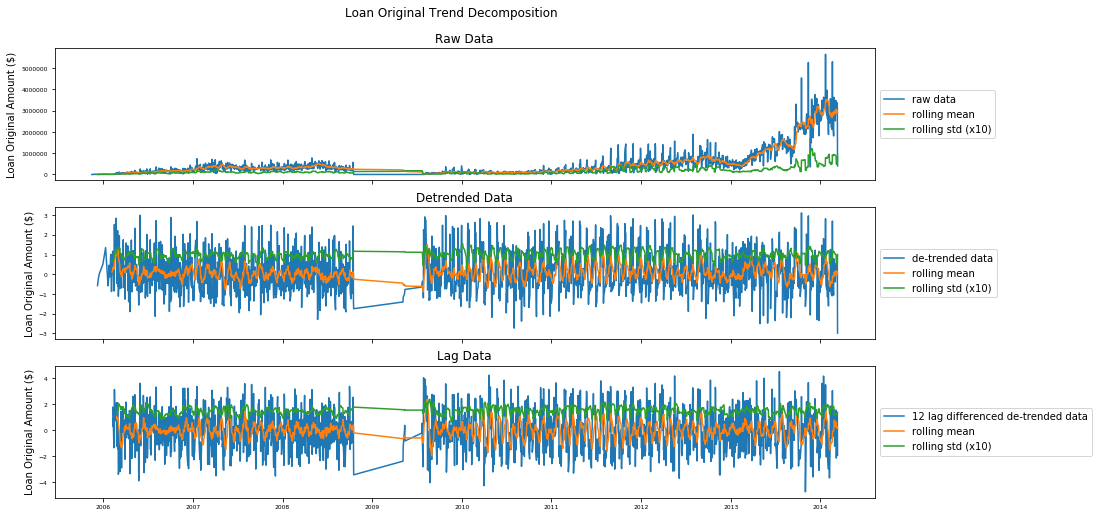

In [68]:
#Plot trend, de-trended and lag 
fig, ax = plt.subplots(3,figsize=computer,sharex=True);

ax[0].plot(sub_df_agg.index, sub_df_agg.values, label='raw data')
ax[0].plot(sub_df_agg.rolling(window=12).mean(), label="rolling mean");
ax[0].plot(sub_df_agg.rolling(window=12).std(), label="rolling std (x10)");
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title_fontsize = 12)
ax[0].set_ylabel('Loan Original Amount ($)')
ax[0].set_title('Raw Data')


ax[1].plot(sub_df_agg.index, de_trend, label="de-trended data")
ax[1].plot(de_trend.rolling(window=12).mean(), label="rolling mean");
ax[1].plot(de_trend.rolling(window=12).std(), label="rolling std (x10)");
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title_fontsize = 12)
ax[1].set_ylabel('Loan Original Amount ($)')
ax[1].set_title('Detrended Data')

ax[2].plot(sub_df_agg.index, lag, label="12 lag differenced de-trended data")
ax[2].plot(lag.rolling(window=12).mean(), label="rolling mean");
ax[2].plot(lag.rolling(window=12).std(), label="rolling std (x10)")
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), title_fontsize = 12)
ax[2].set_ylabel('Loan Original Amount ($)')
ax[2].set_title('Lag Data');
plt.suptitle('Loan Original Trend Decomposition'.title(),y=0.95);

From 2006-2008, the loan amount increases quite slow and can be regarded as stationary. From the second half-year of 2008, there is few loans available due to the financial crisis. This situation last for one more year, at the beginning of 2011 the total loan amount start to grow with a low rate. After a flutuation at the end of 2012, the loan amount rises rapidly from the beginning of 2013. The loan amount peaks at 2014 and goes down a little bit afterwards.

<h3 style="color:SKYBLUE;"><center>Does being a homeowner affect the amount people borrow?</center></h3>

Hypothesis testing: being a homeowner does not affect the amount people borrow. I use $\mu_0$ and $\mu_1$  to present the average loan origincal amount for non-homeowner and homeowenr respectively.

Null hypothesis: $\mu_1 \leq \mu_0$, or $\mu_1-\mu_0 \leq 0$ 

Alternative hypothesis:  $\mu_1 > \mu_0$, or  $\mu_1-\mu_0 > 0$ 


In [35]:
sub_df = df_analysis[['IsBorrowerHomeowner','LoanOriginalAmount']]

In [36]:
org_nohome_mean =sub_df[sub_df.iloc[:,0] == False]['LoanOriginalAmount'].mean()
org_nohome_mean

7033.868293806125

In [37]:
org_home_mean =sub_df[sub_df.iloc[:,0] == True]['LoanOriginalAmount'].mean()
org_home_mean

9617.056560771078

In [38]:
obs_diff = org_home_mean - org_nohome_mean

In [39]:
nohome_means, home_means, diffs = [], [], []

for _ in range(10000):
    bootsamp = sub_df.sample(200, replace = True)
    home_mean = bootsamp[bootsamp.iloc[:,0] == True]['LoanOriginalAmount'].mean()
    nohome_mean = bootsamp[bootsamp.iloc[:,0] == False]['LoanOriginalAmount'].mean()
    # append the info 
    home_means.append(home_mean)
    nohome_means.append(nohome_mean)
    diffs.append(home_mean - nohome_mean)  

In [40]:
np.std(nohome_means),np.std(home_means),np.std(diffs)

(539.594235336305, 673.3604954410486, 860.9004735471967)

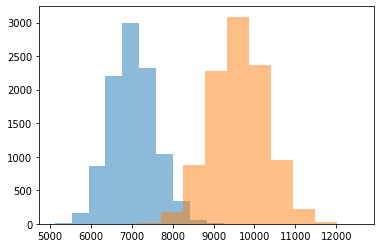

In [41]:
# check the statistic follows normal distribution.
plt.hist(nohome_means, alpha = 0.5);
plt.hist(home_means, alpha = 0.5); 

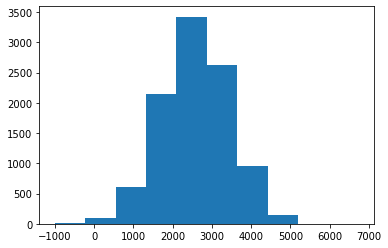

In [42]:
plt.hist(diffs);
std = np.std(diffs)

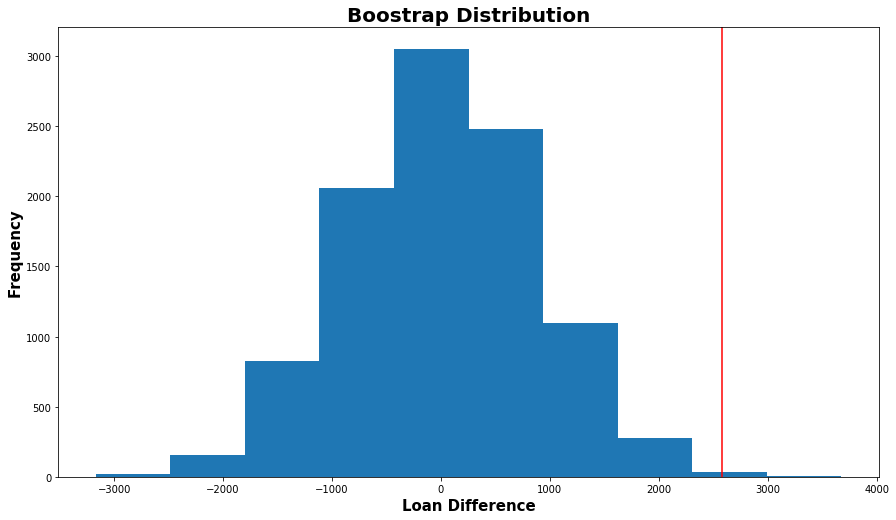

In [43]:
# plot boostrap distribution

plt.figure(figsize=computer)
null_vals = np.random.normal(0, np.std(diffs), 10000)
plt.hist(null_vals)
plt.axvline(x=obs_diff,c='red')
set_labels('Loan Difference','Frequency','Boostrap Distribution')
plt.savefig('hypothesis_testing')

In [44]:
null_vals = np.array(null_vals)
p_val = (null_vals > obs_diff).mean()
p_val

0.0012

p value is less than 0.05. The p-value indicates that being a homeowner affect the amount of loan people borrow.

## Multivariate analysis

<h3 style="color:SKYBLUE;"><center>Who can get a large loan?</center></h3> 

In [45]:
sub_df = df.iloc[:,27:45]
sub_df = pd.concat([sub_df,df['LoanOriginalAmount']],axis=1)
row, col = sub_df.shape
sub_df.head(5)

,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),LoanOriginalAmount
0,2001-10-11 00:00:00,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,0.0,0.00,1500.0,11.0,0.81,9425
1,1996-03-18 00:00:00,14.0,14.0,29.0,13,389.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,3989.0,0.21,10266.0,29.0,1.00,10000
2,2002-07-27 00:00:00,NaN,NaN,3.0,0,0.0,0.0,1.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3001
3,1983-02-28 00:00:00,5.0,5.0,29.0,7,115.0,0.0,1.0,4.0,10056.0,14.0,0.0,0.0,1444.0,0.04,30754.0,26.0,0.76,10000
4,2004-02-20 00:00:00,19.0,19.0,49.0,6,220.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,6193.0,0.81,695.0,39.0,0.95,15000


In [46]:
# Plot funciton
def multi_plot(labels,x_label,y_label):
    fig, axs = plt.subplots(1,len(labels)-1,figsize=computer,sharey=True)
    set_ticks(0,40000,10000,'K','y')
    for i in range(len(labels)-1):
        sns.scatterplot(x = labels[i], y = 'LoanOriginalAmount', data = sub_df, ax = axs[i],alpha = 0.01)
        axs[i].set_ylabel(y_label.title(),fontsize = 15, weight = "bold")
        axs[i].set_xlabel(labels[i].title(),fontsize = 15, weight = "bold")
    fig.suptitle((y_label + ' vs. '+ x_label).title(),fontsize = 20, weight = "bold");

**Loan Orignal Amount vs. Credit Lines**

In [47]:
labels = ['CurrentCreditLines','OpenCreditLines','TotalCreditLinespast7years','LoanOriginalAmount']

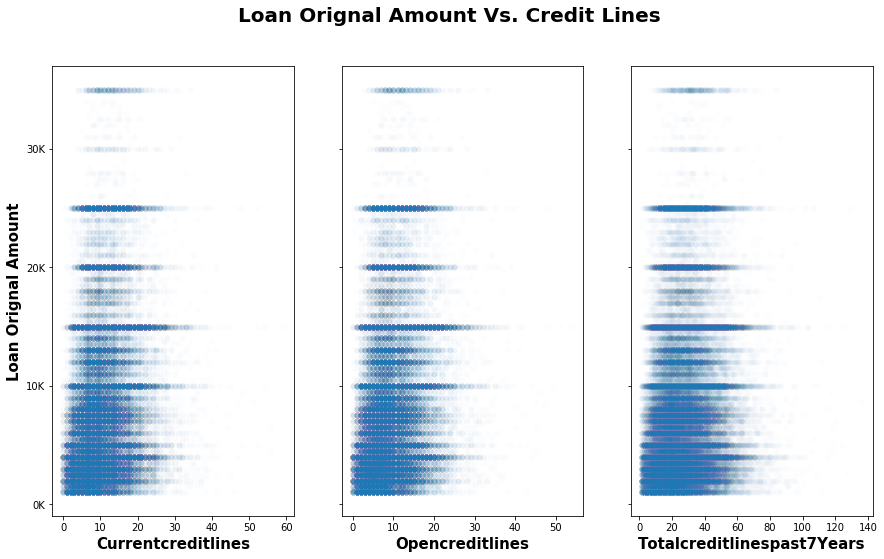

In [48]:
multi_plot(labels,'Credit Lines','Loan Orignal Amount');

**LoanOrignialAmount vs. CreditLines comments**: The scatter plots show that a borrower with 10-20 current credit lines are more likely to borrow more money while it is almost impossible to apply for a loan if a borrower has more than 40 creditline at present. The borrowers with less than 5 credit lines tend to have a loan below 25K. In conclusion, Prosper should target the borrowers with 10-20 credit lines if promoting large loans.


**LoanOrignialAmount vs. Revolving Data**

In [49]:
Revolving = ['OpenRevolvingAccounts','OpenRevolvingMonthlyPayment','LoanOriginalAmount']

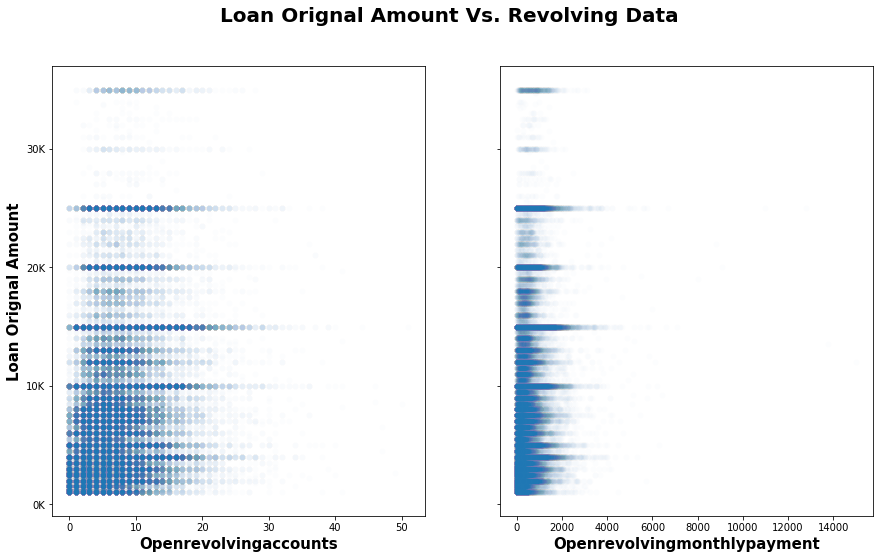

In [50]:
multi_plot(Revolving,'Revolving Data','Loan Orignal Amount')
plt.savefig('Revolving')

**LoanOrignialAmount vs. Revolving Data comments**: The scatter plots show that the borrower with low monthly revolving payments are more likely to get a large loan, while the loan size have an uniform distribution in the revolving accounts interval 10-20. In conclusion, Prosper should target the borrowers with fewer debts if promoting large loans.

**Loan Orignial Amount vs. Inquries Data**

In [51]:
inquries = ['InquiriesLast6Months','TotalInquiries','LoanOriginalAmount']

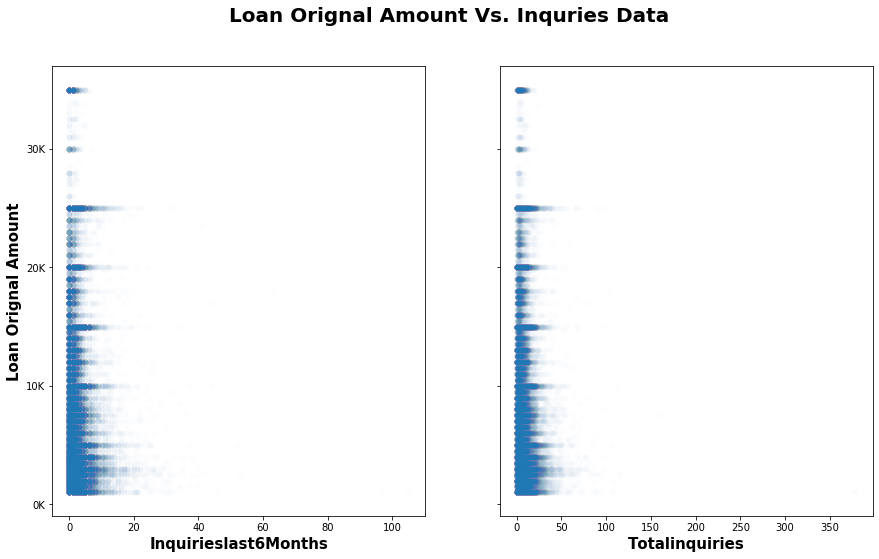

In [52]:
multi_plot(inquries,'Inquries Data','Loan Orignal Amount')
plt.savefig('Inquries')

**Loan Orignial Amount vs. Inquries Data comments**: It is more likely to get a large loan if the borrower have less than 15 inquiries within the last 6 months. 

**Loan Orignial Amount vs. Delinquet Data**

In [53]:
delinquet = ['CurrentDelinquencies','AmountDelinquent','DelinquenciesLast7Years','LoanOriginalAmount']

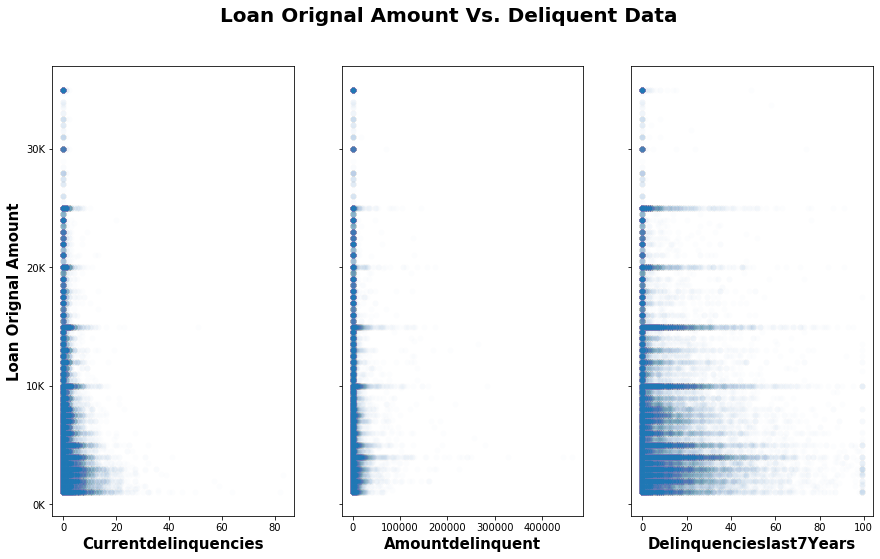

In [54]:
multi_plot(delinquet,'Deliquent Data','Loan Orignal Amount')
plt.savefig('DeliquentData')

**Loan Orignial Amount vs. Delinquet Data comments**: According to the plots, the borrowers with a small amount of delinquet and few delinquet records are more likely to get a large loan (35K). A borrower with more than 20 current delinquencies and/or more than 10K dollars loan(s) are almost impossible to get a loan.

**Loan Orignial Amount vs. Public Records**

In [55]:
Public_records = ['PublicRecordsLast10Years','PublicRecordsLast12Months','LoanOriginalAmount']

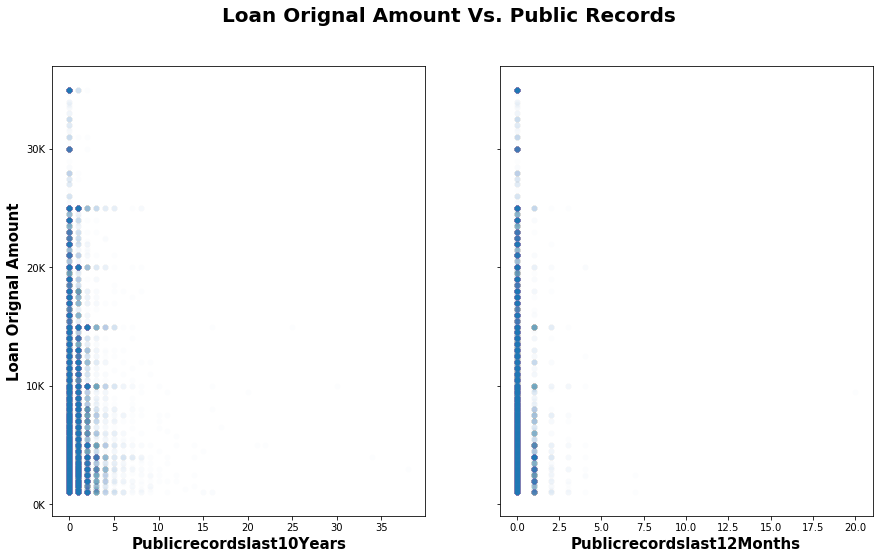

In [56]:
multi_plot(Public_records,'Public Records','Loan Orignal Amount')
plt.savefig('Public Records')

**Loan Orignial Amount vs. Public Records comments**: The large loan only avaiable for citizens with less or equal to 2 public records.

In conclusion, you are more likely to get a large loan if you meet the following criteria:

* Holding 10-20 current credit lines
* No open revolving monthly payment
* Fewer than 15 credit bureau inquiries within the last six months
* No delinquet
* Minimum of 2 public records

<h1 style="color:SKYBLUE;"><center>For Lenders</center></h1> 

<h3 style="color:SKYBLUE;"><center>How does the length of the loan (Term) affect the lenders Estimated Return?</center></h3> 

According to the dataset, the lenders estimated return only applicable for loans originated after July 200

In [57]:
sub_df = df_analysis[['EstimatedReturn','BorrowerAPR','Term']]
sub_df.groupby('Term')['EstimatedReturn'].describe()

,count,mean,std,min,25%,50%,75%,max
Term,,,,,,,,
1_year,1613.0,0.060680,0.025066,0.0146,0.04200,0.05630,0.0682,0.1270
3_year,58695.0,0.094762,0.031148,-0.1827,0.07192,0.09211,0.1150,0.2837
5_year,24545.0,0.101517,0.026798,0.0463,0.08027,0.09414,0.1214,0.1755


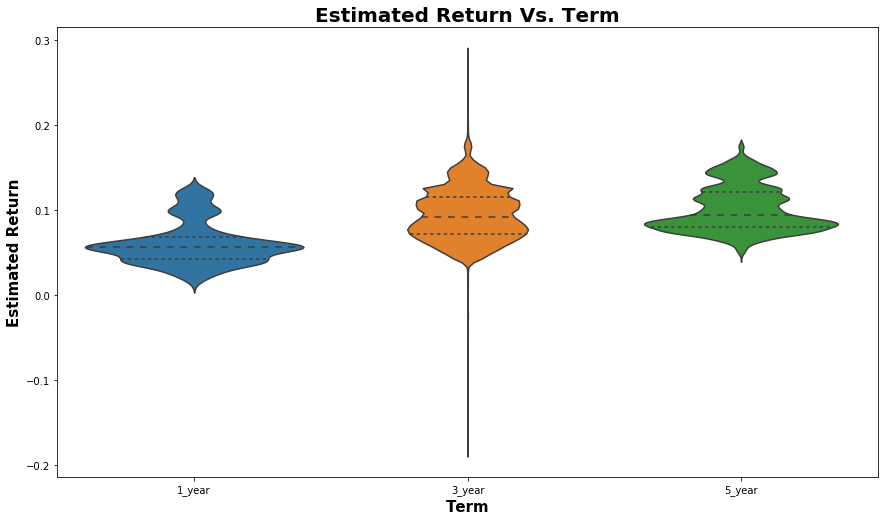

In [58]:
plt.figure(figsize=computer)
sns.violinplot(x='Term',y='EstimatedReturn',data=sub_df,inner='quartile', order=["1_year", "3_year", "5_year"])
set_labels('Term','Estimated Return');

For 1-year term loan, the expected return is 6.08%. Whilreas for the 3-year term loan, the lender can expected a 9.4% return. The highest expected return belongs to 5-year term loan which is 10.2%. Among all three kinds of loan, the 3-year term has a rather high variance while 1-year term loan and 5-year term loan are more stable.In conclusion, longer term are more likely to recieve a higher estimated return. Therefore the investor should considering to offer more 5-year term loans for client if possible.

The investors should considering to offer more 5-year term loans for client if possible.

<h3 style="color:SKYBLUE;">Lender yield vs. List category vs. Borrower states.</h3>

In [59]:
sub_df = df_analysis[['ListingCategory (numeric)','BorrowerState','LenderYield']]

**Listing Category**

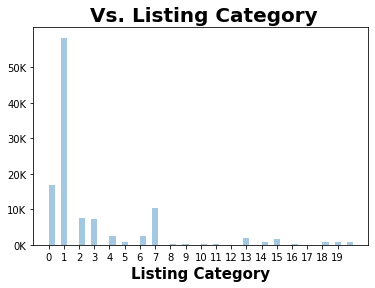

In [60]:
sns.distplot(sub_df['ListingCategory (numeric)'],kde=False)
set_ticks(0,60000,10000,'K','y')
set_ticks(0,20,1,'','x',1)
set_labels("Listing Category",'')
plt.savefig('ListingCategory (numeric)')
plt.savefig('ListingCategory')

**BorrowerState**

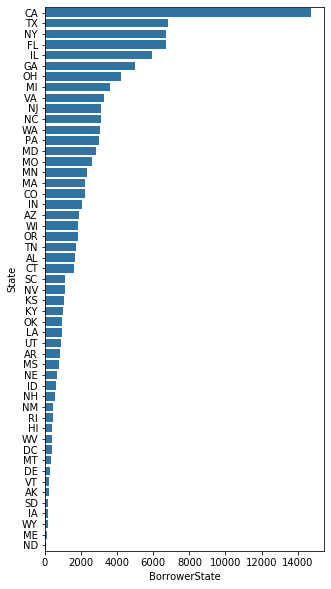

In [61]:
plt.figure(figsize=(5,10))
c = sns.color_palette()[0]
Br_df = sub_df['BorrowerState'].value_counts().reset_index()
ax = sns.barplot(y = Br_df.iloc[:,0], x = Br_df.iloc[:,1],color=c,orient="h")
plt.ylabel('State');
plt.savefig('State')
plt.savefig('BorrowerState')

**Listing Category vs. Lender Yield**

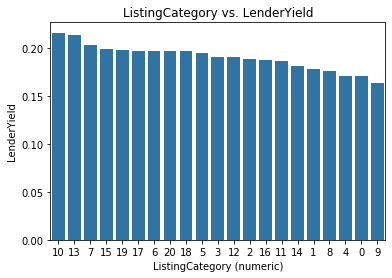

In [62]:
c = sns.color_palette()[0]
plot = sub_df.groupby('ListingCategory (numeric)').mean().sort_values(by='LenderYield',ascending=False)
lc_order=plot.index
sns.barplot(plot.index,plot.values.T[0],color = c,order=plot.index)
plt.ylabel('LenderYield')
plt.title('ListingCategory vs. LenderYield');
plt.savefig('ListingCategoryvs_LenderYield')

**BorrowerState vs. LenderYield**

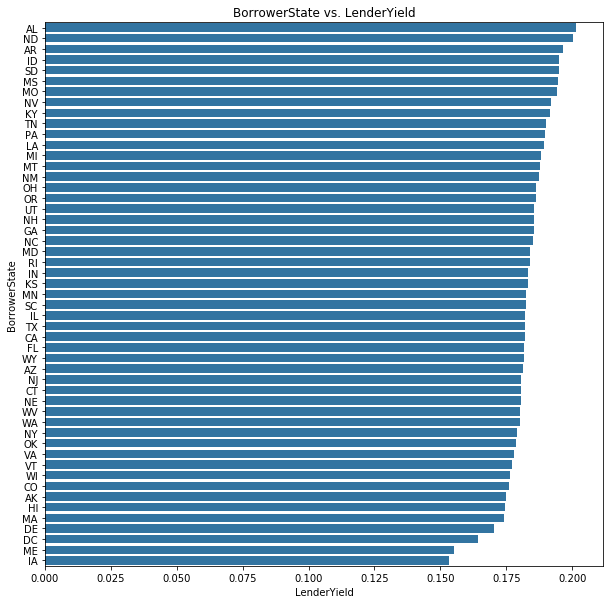

In [63]:
plt.figure(figsize=(10,10))
c = sns.color_palette()[0]
plot = sub_df.iloc[:,1:3].groupby('BorrowerState').mean().sort_values(by='LenderYield',ascending=False)
br_order=list(plot.index)
br_order.reverse()
sns.barplot(plot.values.T[0],plot.index,color = c,order=plot.index,orient='h');
plt.ylabel('BorrowerState')
plt.xlabel('LenderYield')
plt.title('BorrowerState vs. LenderYield');
plt.savefig('BorrowerStatevsLenderYield')

#### Listing Category (numeric) vs. Borrower State vs. Loan Original Amount

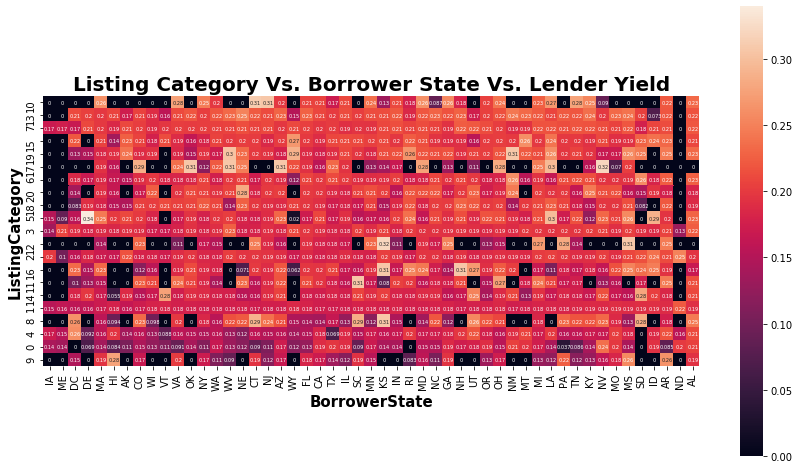

In [64]:
plt.figure(figsize=computer)
piv = pd.pivot_table(sub_df, values="LenderYield",index=["ListingCategory (numeric)"], columns=["BorrowerState"], fill_value=0)
piv = piv.reindex(index=lc_order, columns=br_order)
ax = sns.heatmap(piv, xticklabels=br_order,
    yticklabels=lc_order,square=True,annot=True,
    fmt='.2g',annot_kws={"fontsize":5})
plt.rc('xtick', labelsize=6) 
plt.rc('ytick', labelsize=6) 
ax.set_xlabel("BorrowerState",fontsize = 15,weight = "bold")
ax.set_ylabel("ListingCategory",fontsize = 15,weight = "bold")
plt.title(('Listing Category vs. Borrower State vs. Lender Yield').title(),fontsize=20,weight = "bold");
plt.savefig('heat_map')

The maximum lender yield appears in Delaware with listing category 5. However, the bivariate analysis shows that the lender yield distributed relatively uniform across these two variables. More investigation is required in order to find out what drives a high lender yield.